# Fake News Detection by Stance Prediction

The task is to detect fake news by **predicting the stance** associated to every news article in the __[FNC Dataset](https://github.com/FakeNewsChallenge/fnc-1)__.

**Made for execution with Google's Colab.**


In [3]:
# install requirements
!pip install transformers sentence-transformers tqdm ipdb pytorch-lightning comet-ml &> /dev/null  # &> /dev/null silences output

# download dataset
!git clone https://github.com/FakeNewsChallenge/fnc-1.git &> /dev/null


# must be imported first
import comet_ml
from pytorch_lightning.loggers import CometLogger


from copy import deepcopy as copy
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import os
import pandas as pd
import pytorch_lightning as pl
import random
from scipy.spatial.distance import cosine
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import tensorboard
import torch
import torch.nn as nn
from torch.utils import data
from transformers import BertModel, BertTokenizer
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

# specify the seed for reproducability
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


comet_ml is installed but `COMET_API_KEY` is not set.
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



## Data Input, Preprocessing & Feature Extraction

Prepare BERT transformer for tokenizing

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
LEN_MAX_INPUT = tokenizer.max_model_input_sizes['bert-base-cased']

In [19]:
sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')

You try to use a model that was created with version 1.2.0, however, your version is 1.1.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





Read csv files into Pandas DataFrames, tokenize and merge them on `Body ID`


In [6]:
def tokenize_helper(sentence):
    tokenized = tokenizer.encode_plus(sentence, truncation=True,
            max_length=LEN_MAX_INPUT, add_special_tokens=True,
            return_token_type_ids=False, padding='max_length', 
            return_attention_mask=True, return_tensors='pt'
    )
    ids = tokenized['input_ids']
    atn = tokenized['attention_mask']
    return ids, atn


In [22]:
merged = [None] * 2
p = '/content/fnc-1/'
for idx, prefix in enumerate([p+'train', p+'competition_test']):
    body_df = pd.read_csv(f'{prefix}_bodies.csv', index_col=0)
    body_df[['body_tkns', 'body_attn_mask']] = pd.DataFrame(
        body_df['articleBody'].progress_apply(tokenize_helper).tolist(),
        index=body_df.index)
    body_df['body_sbert'] = body_df['articleBody'].progress_apply(sbert.encode,
                                                                  convert_to_tensor=True)

    stance_df = pd.read_csv(f'{prefix}_stances.csv')
    stance_df[['head_tkns', 'head_attn_mask']] = pd.DataFrame(
        stance_df['Headline'].progress_apply(tokenize_helper).tolist(),
        index=stance_df.index)
    stance_df['head_sbert'] = stance_df['Headline'].progress_apply(sbert.encode,
                                                                   convert_to_tensor=True)

    
    merged_df = pd.merge(stance_df, body_df, on='Body ID')
    merged_df = merged_df.rename(
        columns={'Headline': 'headline', 'Body ID': 'body_id',
                     'Stance': 'stance', 'articleBody': 'body'}
    )
    merged[idx] = merged_df

train_df, test_df = merged
print(test_df['body_sbert'])



0        [tensor(0.0622), tensor(0.4705), tensor(-0.179...
1        [tensor(0.0622), tensor(0.4705), tensor(-0.179...
2        [tensor(0.0622), tensor(0.4705), tensor(-0.179...
3        [tensor(0.0622), tensor(0.4705), tensor(-0.179...
4        [tensor(0.0622), tensor(0.4705), tensor(-0.179...
                               ...                        
25408    [tensor(-0.0683), tensor(0.0012), tensor(-0.10...
25409    [tensor(-0.0683), tensor(0.0012), tensor(-0.10...
25410    [tensor(-0.0683), tensor(0.0012), tensor(-0.10...
25411    [tensor(-0.0683), tensor(0.0012), tensor(-0.10...
25412    [tensor(-0.0683), tensor(0.0012), tensor(-0.10...
Name: body_sbert, Length: 25413, dtype: object


In [23]:
len_train = len(train_df)
sample_indices = random.sample(range(len_train), k=int(0.2*len_train))

val_df = train_df.iloc[sample_indices].reset_index(drop=True)
train_df = train_df.drop(sample_indices).reset_index(drop=True)


## Data Exploration

### Stance Frequency

The training dataset consists of 39978 headline and article pairs.
The validation dataset consists of 9994 headline and article pairs.
The test dataset consists of 25413 headline and article pairs.


                                                headline  ...                                         body_sbert
7602   Militant Group Says It Killed American Journal...  ...  [tensor(-0.0159), tensor(0.2476), tensor(-0.47...
9287   ISIS militants appear to behead abducted Ameri...  ...  [tensor(-0.0273), tensor(0.0452), tensor(-0.40...
37270  TBS Speeds up SEINFELD by 7.5% to Add 2 More M...  ...  [tensor(-0.2353), tensor(0.8483), tensor(-0.30...
33058  Boyfriend cuts off his penis and throws it in ...  ...  [tensor(0.2276), tensor(0.1876), tensor(-0.096...
22916  Islamic State, in video titled "A Message to A...  ...  [tensor(-0.1639), tensor(-0.3449), tensor(0.04...
39562          For sale: Tiger's former island in Sweden  ...  [tensor(0.4198), tensor(-0.2271), tensor(0.035...
17863    

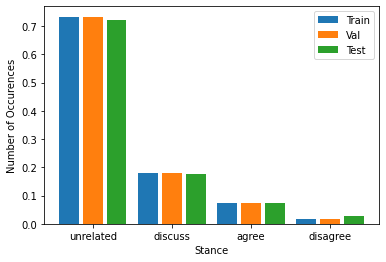

In [24]:
dfs = [train_df, val_df, test_df]
labels = ['training', 'validation', 'test']
df_zip = zip(dfs, labels)
for df, label in df_zip:
    print(f'The {label} dataset consists of {len(df)} headline and article pairs.')

print('\n')

# dropping body text to not clog up output. N.B. drop is not inplace by default
print(train_df.drop(columns=['body', 'body_attn_mask', 'body_tkns', 
                             'head_attn_mask', 'head_tkns']).sample(10))   
print('\n')

train_counts = train_df['stance'].value_counts(normalize=True)
test_counts = test_df['stance'].value_counts(normalize=True)

val_counts = val_df['stance'].value_counts(normalize=True)

plt.figure()
pos = np.array(range(len(train_counts.index)))
plt.bar(pos - 0.3,train_counts.values, width=0.25, label='Train')
plt.bar(pos - 0.0,val_counts.values, width=0.25, label='Val')
plt.bar(pos + 0.3,test_counts.values, width=0.25, label='Test')
plt.legend()
plt.xlabel('Stance')
plt.ylabel('Number of Occurences')

plt.xticks(pos, train_counts.index)

plt.show()


### BERT Token Exploration


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(0.0, 512.0)

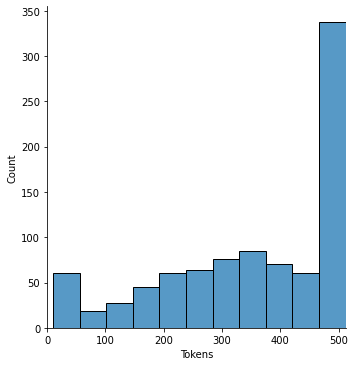

In [25]:
len_tokens = []
max_len = tokenizer.max_model_input_sizes['bert-base-cased']
for text in pd.read_csv(f'{prefix}_bodies.csv', index_col=0).articleBody:
    tokens = tokenizer.encode(text, max_length=max_len)
    len_tokens.append(len(tokens))

sns.displot(len_tokens)
plt.xlabel('Tokens')
plt.xlim([0, max_len])

## TF/IDF Extraction

Uses the `scikit-learn` module's implementation of TF/IDF. Built on both the headlines and bodies in the train dataset, and fit to both the train and test dataset.


In [26]:
stop = set(stopwords.words('english')) 
vectorizer = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2,
                             stop_words=stop, max_features=10_000)
raw_text = np.unique(pd.concat(dfs)[['headline', 'body']].values)

tfidf = vectorizer.fit(raw_text.astype('U'))

# keep it sparse, save the rams
body_tfidf = {label: tfidf.transform(df['body']) for df, label in zip(dfs, labels)}
head_tfidf = {label: tfidf.transform(df['headline']) for df, label in zip(dfs, labels)}


#### Sampling ten random features from the TF/IDF dictionary

In [27]:
print(random.sample(vectorizer.get_feature_names(), 10))

['approximately', 'followed', 'arrogant', 'imminent', 'preferred', 'super', 'referred', 'layoffs', '2007', 'packs']


## Create Datasets


In [58]:
from math import isnan

class TFIDFDataset(data.Dataset):

    def __init__(self, df, output_vectors=False, binary=True):
        self.df = copy(df)
        self.output_vectors = output_vectors
        self.binary = binary
        self.feature_length = 1 + 2 * len(df.at[0, 'head'])



    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        items = self.df.iloc[idx]
        headline = items['head'].reshape(-1, 1)
        body = items['body'].reshape(-1, 1)
        distance = cosine(headline, body).reshape(-1, 1)

        stance = items['stance']
        if self.binary:
            stance = float(stance != 0)
        
        stance = torch.tensor(stance)

        if self.output_vectors:
            cat = np.concatenate([distance, headline, body])
            return torch.tensor(cat, dtype=torch.float), stance

        return distance, stance


In [59]:
class BERTDataset(data.Dataset):

    def __init__(self, df, output_vectors=False, binary=True):
        self.df = copy(df)
        self.output_vectors = output_vectors
        self.binary = binary
        if output_vectors:
            self.feature_length = 768*2
        else:
            self.feature_length = 1


    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        items = self.df.iloc[idx]
        stance = items['stance']
        if self.binary:
            stance = float(stance != 0)
        
        stance = torch.tensor(stance)
        
        head = items['head']
        body = items['body']
        if self.output_vectors:
            head_mask = items['head_mask']
            body_mask = items['body_mask']

            tokens = torch.cat((head, body))
            mask = torch.cat((head_mask, body_mask))
            return (tokens, mask), stance

        distance = cosine(head, body).reshape(-1, 1)
        return distance, stance

In [30]:
stance_mapping = {'unrelated': 0, 'discuss': 1, 'agree': 2, 'disagree': 3}

In [60]:
ML_dfs = (dfs[0], dfs[2])
ML_labels = (labels[0], labels[2])

tfidf_sets = [[None] for _ in ML_dfs]
BERT_sets = [[None] for _ in ML_dfs]
for idx, (df, label) in enumerate(zip(ML_dfs, ML_labels)):
    set_df = pd.DataFrame()
    set_df['stance'] = df['stance'].apply(lambda x: stance_mapping[x])
    set_df['body'] = pd.Series(list(body_tfidf[label].toarray()))
    set_df['head'] = pd.Series(list(head_tfidf[label].toarray()))
    tfidf_sets[idx] = TFIDFDataset(set_df)

    set_df['body'] = df['body_sbert']
    set_df['head'] = df['head_sbert']
    BERT_sets[idx] = BERTDataset(set_df)


# Related / Unrelated Classification


## Simple ML Method: Logistic Regression

Statsmodels Logistic Regression, trained on the whole training dataset

In [68]:
for sets, label in zip([tfidf_sets, BERT_sets], ['TF/IDF', 'SBERT']):
    split_sets = [np.split(np.array(s), 2, axis=1) for s in sets]
    (train_X, train_Y), (test_X, test_Y) = split_sets
    train_Y = train_Y.ravel().astype('int')
    test_Y = test_Y.ravel().astype('int')

    model = LogisticRegression(max_iter=2000, random_state=SEED)
    model.fit(train_X, train_Y)
    print(f'{label} Results:')
    print(metrics.classification_report(test_Y, model.predict(test_X)))

    smote = SMOTE(random_state=SEED)
    train_X, train_Y = smote.fit_resample(train_X, train_Y)

    model.fit(train_X, train_Y)
    print(f'Oversampled {label} Results:')
    print(metrics.classification_report(test_Y, model.predict(test_X)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



TF/IDF Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     18349
           1       0.98      0.89      0.93      7064

    accuracy                           0.96     25413
   macro avg       0.97      0.94      0.95     25413
weighted avg       0.96      0.96      0.96     25413



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Oversampled TF/IDF Results:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     18349
           1       0.96      0.93      0.94      7064

    accuracy                           0.97     25413
   macro avg       0.96      0.96      0.96     25413
weighted avg       0.97      0.97      0.97     25413



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



SBERT Results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18349
           1       0.96      0.95      0.96      7064

    accuracy                           0.98     25413
   macro avg       0.97      0.97      0.97     25413
weighted avg       0.98      0.98      0.98     25413



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Oversampled SBERT Results:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18349
           1       0.93      0.98      0.95      7064

    accuracy                           0.97     25413
   macro avg       0.96      0.98      0.97     25413
weighted avg       0.98      0.97      0.97     25413



## Deep Learning Method: GRU


In [13]:
tfidf_sets = [[None] for _ in dfs]
BERT_sets = [[None] for _ in dfs]
for idx, (df, label) in enumerate(zip(dfs, labels)):
    set_df = pd.DataFrame() 
    set_df['stance'] = df['stance'].apply(lambda x: stance_mapping[x])
    set_df['body'] = pd.Series(list(body_tfidf[label].toarray()))
    set_df['head'] = pd.Series(list(head_tfidf[label].toarray()))
    tfidf_sets[idx] = TFIDFDataset(set_df, output_vectors=True)

    set_df['body'] = df['body_tkns']
    set_df['body_mask'] = df['body_attn_mask']
    set_df['head'] = df['head_tkns']
    set_df['head_mask'] = df['head_attn_mask']
    BERT_sets[idx] = BERTDataset(set_df, output_vectors=True)


In [22]:
class BinaryGRU(pl.LightningModule):
    def __init__(self, sets, hidden_size=768, batch_size=32, lr=1e-3, bert=None):
        super().__init__()
        self.sets = sets
        self.in_size = sets[0].feature_length
        self.lr = lr
        self.batch_size = batch_size
        self.bert = bert
        
        self.GRU = nn.GRU(input_size=self.in_size, hidden_size=hidden_size, 
                          batch_first=True, num_layers=5)
        self.ReLU = nn.ReLU()
        self.Linear = nn.Linear(hidden_size, 1)
        self.Sigmoid = nn.Sigmoid()
        self.loss_fn = nn.BCELoss()



    
    def forward(self, x):
        if self.bert is not None:
            ids, attns = x
            head_id, body_id = torch.split(ids, 1, dim=1)
            head_attn, body_attn = torch.split(attns, 1, dim=1)
            with torch.no_grad():
                head_x = self.bert(input_ids=head_id.squeeze(),
                                       attention_mask=head_attn.squeeze())[1]
                body_x = self.bert(input_ids=body_id.squeeze(),
                                       attention_mask=body_attn.squeeze())[1]
            
                x = torch.cat((head_x, body_x), dim=1)

        x = x.view(self.batch_size, 1, self.in_size)
        x, _ = self.GRU(x)
        x = self.ReLU(x)
        x = self.Linear(x)
        x = self.Sigmoid(x)
        return x.squeeze()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.log('lr', self.lr)
        return optimizer
    

    def train_dataloader(self):
        return data.DataLoader(self.sets[0], batch_size=self.batch_size, 
                               shuffle=False, drop_last=True, num_workers=4, pin_memory=True)


    def training_step(self, batch, idx):
        x, y = batch
        y = y.float()
        z = self.forward(x)
        loss = self.loss_fn(z, y)
        self.log('train_loss', loss)
        return loss


    def val_dataloader(self):
        return data.DataLoader(self.sets[1], batch_size=self.batch_size, 
                               shuffle=False, drop_last=True, num_workers=4, pin_memory=True)

    
    def validation_step(self, batch, idx):
        x, y = batch
        y = y.float()
        z = self.forward(x)
        loss = self.loss_fn(z, y)
        self.log('val_loss', loss)
        return loss
    

    def test_dataloader(self):
        return data.DataLoader(self.sets[2], batch_size=self.batch_size, 
                               shuffle=False, drop_last=True, num_workers=4, pin_memory=True)


    def test_step(self, batch, idx):
        x, y = batch
        y = y.float()
        z = self.forward(x)
        loss = self.loss_fn(z, y)
        self.log('test_loss', loss)
        accuracy = torch.sum(torch.round(z) == y) / len(y)
        self.log('test_acc', accuracy)
        return loss


In [ ]:
print(tfidf_sets[0].outsize)

20001


In [39]:
comet_logger = CometLogger(
    api_key='zec9nIWkkarCcQbsME2CwpqWT',
    workspace=os.environ.get('guymccombe'),
    project_name='FNC',
    experiment_name='TFIDF Binary'
)

model = BinaryGRU(tfidf_sets, batch_size=512)
trainer = pl.Trainer(gpus=1, max_epochs=25, logger=comet_logger)
trainer.tune(model)
trainer.fit(model)
trainer.test()

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/guymccombe/fnc/3826e0967c6d4c21a1b42513231004d1
COMET INFO:   Metrics:
COMET INFO:     test_acc  : 0.8832070827484131
COMET INFO:     test_loss : 0.4778502583503723
COMET INFO:   Others:
COMET INFO:     Name : TFIDF Binary
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: -----------------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/guymccom

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/guymccombe/fnc/02d511453d984f558dafc1ae0d7d0e42
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [195]      : (0.0003518810262903571, 0.6870293617248535)
COMET INFO:     train_loss [39] : (0.0005035420181229711, 0.5773001909255981)
COMET INFO:     val_loss [25]   : (0.01674310863018036, 0.5629283785820007)
COMET INFO:   Others:
COMET INFO:     Name : TFIDF Binary
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/guymccombe/fnc/02d511453d984f558dafc1ae0d7d0e42




--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8559470772743225, 'test_loss': 0.3914671838283539}
--------------------------------------------------------------------------------


[{'test_loss': 0.3914671838283539, 'test_acc': 0.8559470772743225}]

In [24]:
comet_logger = CometLogger(
    api_key='zec9nIWkkarCcQbsME2CwpqWT',
    workspace=os.environ.get('guymccombe'),
    project_name='FNC',
    experiment_name='BERT Binary'
)
bert = BertModel.from_pretrained('bert-base-cased')
model = BinaryGRU(BERT_sets, bert=bert, batch_size=128)
trainer = pl.Trainer(gpus=1, max_epochs=5, logger=comet_logger, auto_lr_find=True)
trainer.tune(model)
trainer.fit(model)
trainer.test()

CometLogger will be initialized in online mode
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES:

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
Learning rate set to 0.0013182567385564075
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/guymccombe/fnc/f7a7632d18c84e4ba82be170f584bb31
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [167]      : (0.2150564193725586, 1.0156004428863525)
COMET INFO:     train_loss [31] : (0.3673325777053833, 0.8881785273551941)
COMET INFO:     val_loss [5]    : (0.6343417763710022, 0.7353286743164062)
COMET INFO:   Others:
COMET INFO:     Name : BERT Binary
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     os packages         : 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: Set model graph ignored; already called. Call with overwrite=True to replace graph definition



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7239977717399597, 'test_loss': 0.6320745348930359}
--------------------------------------------------------------------------------


[{'test_loss': 0.6320745348930359, 'test_acc': 0.7239977717399597}]